# On the Learning Rate of Focal Loss with on Big Models

## 1. Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### 1.1 Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### 1.2 Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### 1.3 Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


## 2. Model

## 2.1 Define the Neural Network

In [5]:
## define a model which has a softmax layer as the last layer, which is significant when considering L1 Loss and Focal Loss
class ConvNet_DIY(nn.Module):
    def __init__(self):
        super(ConvNet_DIY, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second block
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Third block
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn2(self.conv2(torch.relu(self.bn1(self.conv1(x)))))))
        x = self.pool2(torch.relu(self.bn4(self.conv4(torch.relu(self.bn3(self.conv3(x)))))))
        x = self.pool3(torch.relu(self.bn6(self.conv6(torch.relu(self.bn5(self.conv5(x)))))))
        
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = nn.Softmax(dim=1)(x) 
        return x

### 2.2 Define the Loss Functions and train_batch, testing_batch

In [6]:
# Define Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        
        eps = 1e-6
        probs = inputs.clamp(eps, 1. - eps)
        
        # calculate the loss of each class
        class_loss = -targets * torch.log(probs) * self.alpha * (1 - probs)**self.gamma
        
        # sum up
        loss = class_loss.sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [7]:
##################### Define the 4 required Loss Functions##################
CrossEntropy = nn.CrossEntropyLoss()
L1Loss = nn.L1Loss()
FocalLoss_05 = FocalLoss(gamma=0.5)
FocalLoss_2 = FocalLoss(gamma=2)
###############################################################

In [8]:
def train_batch(model, image, target, loss_fn):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.
        loss_fn (torch.nn.Module, optional): Loss function to compute the loss.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function.
    """
    
    output = model(image) 
    loss = loss_fn(output, target)

    return output, loss

In [9]:
def test_batch(model, image, target, loss_fn):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image) 
    loss = loss_fn(output, target)
    ###############################################################

    return output, loss

In [10]:
## to adjust "target" to one-hot vector

def to_one_hot(targets, num_classes):
    one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
    one_hot.scatter_(1, targets.unsqueeze(1), 1.)
    return one_hot

## 3.  Model Training with Different Learning Rate on Focal Loss with $\gamma=2$

### 3.1 Learning Rate = 0.1

In [11]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [12]:
training_loss_01 = []
training_acc_01 = []
testing_loss_01 = []
testing_acc_01 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_01.append(epoch_loss)
    training_acc_01.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_01.append(val_loss)
        testing_acc_01.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_01 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_01, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0090 Acc: 0.3736
Begin test......
Test Loss: 0.0074 Acc: 0.4898
Epoch: 2/30 Train Loss: 0.0061 Acc: 0.5479
Begin test......
Test Loss: 0.0059 Acc: 0.5578
Epoch: 3/30 Train Loss: 0.0047 Acc: 0.6341
Begin test......
Test Loss: 0.0048 Acc: 0.6434
Epoch: 4/30 Train Loss: 0.0039 Acc: 0.6891
Begin test......
Test Loss: 0.0047 Acc: 0.6716
Epoch: 5/30 Train Loss: 0.0033 Acc: 0.7287
Begin test......
Test Loss: 0.0042 Acc: 0.6816
Epoch: 6/30 Train Loss: 0.0026 Acc: 0.7780
Begin test......
Test Loss: 0.0030 Acc: 0.7602
Epoch: 7/30 Train Loss: 0.0023 Acc: 0.7965
Begin test......
Test Loss: 0.0027 Acc: 0.7796
Epoch: 8/30 Train Loss: 0.0022 Acc: 0.8082
Begin test......
Test Loss: 0.0023 Acc: 0.8091
Epoch: 9/30 Train Loss: 0.0021 Acc: 0.8139
Begin test......
Test Loss: 0.0024 Acc: 0.8031
Epoch: 10/30 Train Loss: 0.0020 Acc: 0.8242
Begin test......
Test Loss: 0.0025 Acc: 0.7953
Epoch: 11/30 Train Loss: 0.0016 Acc: 0.8461
Begin test......
Test Loss: 0.0020 Acc: 0.8342
Epoch: 1

### 3.2 Learning Rate = 0.08

In [13]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [14]:
training_loss_008 = []
training_acc_008 = []
testing_loss_008 = []
testing_acc_008 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_008.append(epoch_loss)
    training_acc_008.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_008.append(val_loss)
        testing_acc_008.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_008 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_008, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0086 Acc: 0.4010
Begin test......
Test Loss: 0.0070 Acc: 0.4653
Epoch: 2/30 Train Loss: 0.0057 Acc: 0.5702
Begin test......
Test Loss: 0.0057 Acc: 0.5802
Epoch: 3/30 Train Loss: 0.0044 Acc: 0.6573
Begin test......
Test Loss: 0.0042 Acc: 0.6828
Epoch: 4/30 Train Loss: 0.0036 Acc: 0.7093
Begin test......
Test Loss: 0.0036 Acc: 0.7239
Epoch: 5/30 Train Loss: 0.0031 Acc: 0.7453
Begin test......
Test Loss: 0.0043 Acc: 0.6804
Epoch: 6/30 Train Loss: 0.0024 Acc: 0.7900
Begin test......
Test Loss: 0.0026 Acc: 0.7863
Epoch: 7/30 Train Loss: 0.0022 Acc: 0.8073
Begin test......
Test Loss: 0.0024 Acc: 0.7956
Epoch: 8/30 Train Loss: 0.0020 Acc: 0.8171
Begin test......
Test Loss: 0.0025 Acc: 0.8030
Epoch: 9/30 Train Loss: 0.0019 Acc: 0.8258
Begin test......
Test Loss: 0.0023 Acc: 0.8108
Epoch: 10/30 Train Loss: 0.0018 Acc: 0.8329
Begin test......
Test Loss: 0.0021 Acc: 0.8228
Epoch: 11/30 Train Loss: 0.0015 Acc: 0.8540
Begin test......
Test Loss: 0.0020 Acc: 0.8328
Epoch: 1

### 3.3 Learning Rate = 0.06

In [15]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.06, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [16]:
training_loss_006 = []
training_acc_006 = []
testing_loss_006 = []
testing_acc_006 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_006.append(epoch_loss)
    training_acc_006.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_006.append(val_loss)
        testing_acc_006.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_006 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_006, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0084 Acc: 0.4112
Begin test......
Test Loss: 0.0070 Acc: 0.5233
Epoch: 2/30 Train Loss: 0.0055 Acc: 0.5826
Begin test......
Test Loss: 0.0055 Acc: 0.6148
Epoch: 3/30 Train Loss: 0.0043 Acc: 0.6596
Begin test......
Test Loss: 0.0042 Acc: 0.6575
Epoch: 4/30 Train Loss: 0.0035 Acc: 0.7124
Begin test......
Test Loss: 0.0036 Acc: 0.7278
Epoch: 5/30 Train Loss: 0.0030 Acc: 0.7490
Begin test......
Test Loss: 0.0029 Acc: 0.7628
Epoch: 6/30 Train Loss: 0.0024 Acc: 0.7933
Begin test......
Test Loss: 0.0026 Acc: 0.7852
Epoch: 7/30 Train Loss: 0.0022 Acc: 0.8053
Begin test......
Test Loss: 0.0024 Acc: 0.8033
Epoch: 8/30 Train Loss: 0.0020 Acc: 0.8190
Begin test......
Test Loss: 0.0023 Acc: 0.8028
Epoch: 9/30 Train Loss: 0.0019 Acc: 0.8247
Begin test......
Test Loss: 0.0023 Acc: 0.8066
Epoch: 10/30 Train Loss: 0.0018 Acc: 0.8346
Begin test......
Test Loss: 0.0023 Acc: 0.8109
Epoch: 11/30 Train Loss: 0.0015 Acc: 0.8548
Begin test......
Test Loss: 0.0019 Acc: 0.8384
Epoch: 1

### 3.4 Learning Rate = 0.05

In [17]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/5, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [18]:
training_loss_005 = []
training_acc_005 = []
testing_loss_005 = []
testing_acc_005 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_005.append(epoch_loss)
    training_acc_005.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_005.append(val_loss)
        testing_acc_005.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_005 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_005, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0077 Acc: 0.4512
Begin test......
Test Loss: 0.0057 Acc: 0.5707
Epoch: 2/30 Train Loss: 0.0048 Acc: 0.6279
Begin test......
Test Loss: 0.0042 Acc: 0.6763
Epoch: 3/30 Train Loss: 0.0037 Acc: 0.6988
Begin test......
Test Loss: 0.0036 Acc: 0.7111
Epoch: 4/30 Train Loss: 0.0032 Acc: 0.7355
Begin test......
Test Loss: 0.0029 Acc: 0.7668
Epoch: 5/30 Train Loss: 0.0028 Acc: 0.7607
Begin test......
Test Loss: 0.0028 Acc: 0.7753
Epoch: 6/30 Train Loss: 0.0023 Acc: 0.8023
Begin test......
Test Loss: 0.0024 Acc: 0.7972
Epoch: 7/30 Train Loss: 0.0021 Acc: 0.8149
Begin test......
Test Loss: 0.0023 Acc: 0.8044
Epoch: 8/30 Train Loss: 0.0020 Acc: 0.8217
Begin test......
Test Loss: 0.0021 Acc: 0.8175
Epoch: 9/30 Train Loss: 0.0019 Acc: 0.8285
Begin test......
Test Loss: 0.0020 Acc: 0.8244
Epoch: 10/30 Train Loss: 0.0017 Acc: 0.8388
Begin test......
Test Loss: 0.0020 Acc: 0.8284
Epoch: 11/30 Train Loss: 0.0015 Acc: 0.8553
Begin test......
Test Loss: 0.0019 Acc: 0.8382
Epoch: 1

### 3.5 Learning Rate = 0.0333

In [19]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/3, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [20]:
training_loss_003 = []
training_acc_003 = []
testing_loss_003 = []
testing_acc_003 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_003.append(epoch_loss)
    training_acc_003.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_003.append(val_loss)
        testing_acc_003.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_003 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_003, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0077 Acc: 0.4528
Begin test......
Test Loss: 0.0061 Acc: 0.5320
Epoch: 2/30 Train Loss: 0.0049 Acc: 0.6163
Begin test......
Test Loss: 0.0044 Acc: 0.6571
Epoch: 3/30 Train Loss: 0.0039 Acc: 0.6886
Begin test......
Test Loss: 0.0043 Acc: 0.7028
Epoch: 4/30 Train Loss: 0.0033 Acc: 0.7292
Begin test......
Test Loss: 0.0033 Acc: 0.7474
Epoch: 5/30 Train Loss: 0.0029 Acc: 0.7548
Begin test......
Test Loss: 0.0031 Acc: 0.7567
Epoch: 6/30 Train Loss: 0.0023 Acc: 0.8003
Begin test......
Test Loss: 0.0025 Acc: 0.7954
Epoch: 7/30 Train Loss: 0.0021 Acc: 0.8130
Begin test......
Test Loss: 0.0026 Acc: 0.7803
Epoch: 8/30 Train Loss: 0.0020 Acc: 0.8196
Begin test......
Test Loss: 0.0024 Acc: 0.8095
Epoch: 9/30 Train Loss: 0.0018 Acc: 0.8330
Begin test......
Test Loss: 0.0025 Acc: 0.7962
Epoch: 10/30 Train Loss: 0.0018 Acc: 0.8362
Begin test......
Test Loss: 0.0020 Acc: 0.8297
Epoch: 11/30 Train Loss: 0.0015 Acc: 0.8589
Begin test......
Test Loss: 0.0019 Acc: 0.8449
Epoch: 1

### 3.6 Learning Rate = 0.01

In [21]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [22]:
training_loss_001 = []
training_acc_001 = []
testing_loss_001 = []
testing_acc_001 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_001.append(epoch_loss)
    training_acc_001.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_001.append(val_loss)
        testing_acc_001.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_001 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_001, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0077 Acc: 0.4602
Begin test......
Test Loss: 0.0056 Acc: 0.5832
Epoch: 2/30 Train Loss: 0.0046 Acc: 0.6426
Begin test......
Test Loss: 0.0045 Acc: 0.6691
Epoch: 3/30 Train Loss: 0.0037 Acc: 0.7029
Begin test......
Test Loss: 0.0047 Acc: 0.6627
Epoch: 4/30 Train Loss: 0.0032 Acc: 0.7368
Begin test......
Test Loss: 0.0033 Acc: 0.7380
Epoch: 5/30 Train Loss: 0.0028 Acc: 0.7622
Begin test......
Test Loss: 0.0028 Acc: 0.7717
Epoch: 6/30 Train Loss: 0.0023 Acc: 0.8003
Begin test......
Test Loss: 0.0026 Acc: 0.7926
Epoch: 7/30 Train Loss: 0.0022 Acc: 0.8105
Begin test......
Test Loss: 0.0025 Acc: 0.7959
Epoch: 8/30 Train Loss: 0.0020 Acc: 0.8188
Begin test......
Test Loss: 0.0024 Acc: 0.8036
Epoch: 9/30 Train Loss: 0.0019 Acc: 0.8273
Begin test......
Test Loss: 0.0022 Acc: 0.8190
Epoch: 10/30 Train Loss: 0.0018 Acc: 0.8341
Begin test......
Test Loss: 0.0022 Acc: 0.8194
Epoch: 11/30 Train Loss: 0.0016 Acc: 0.8508
Begin test......
Test Loss: 0.0020 Acc: 0.8365
Epoch: 1

## 4. Draw the pictures to compare the results

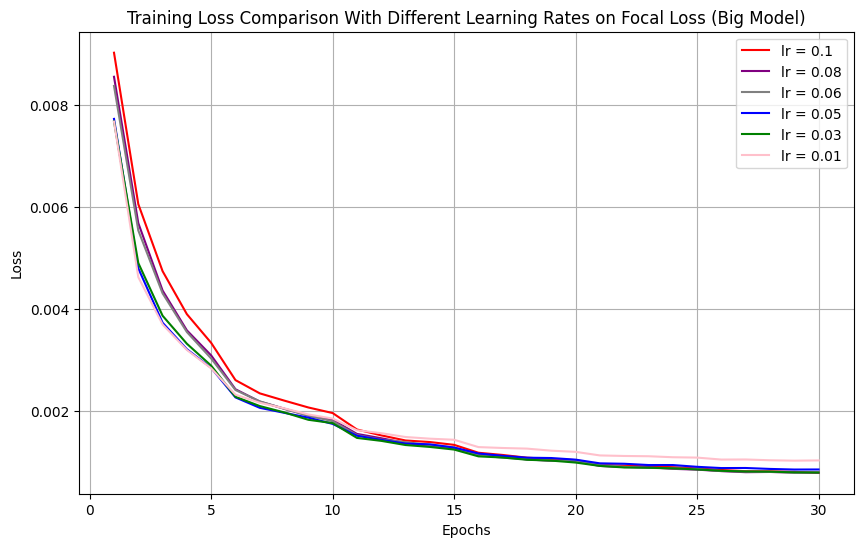

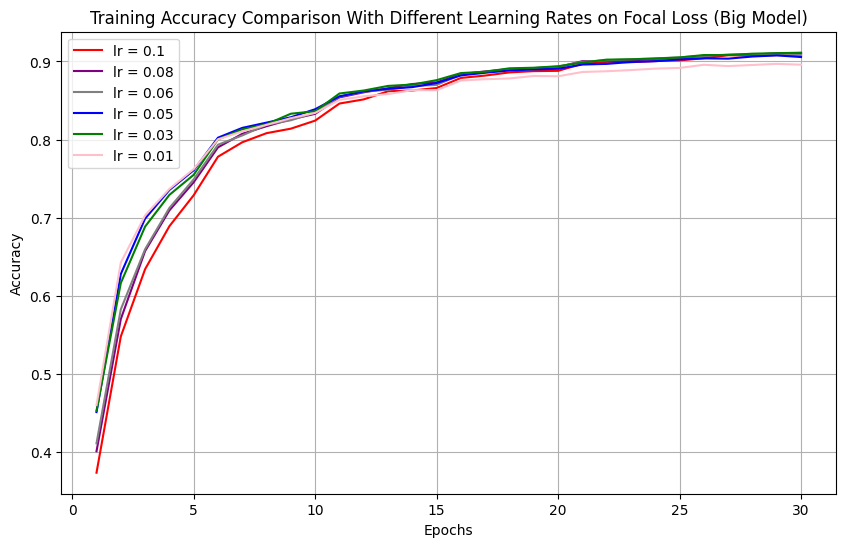

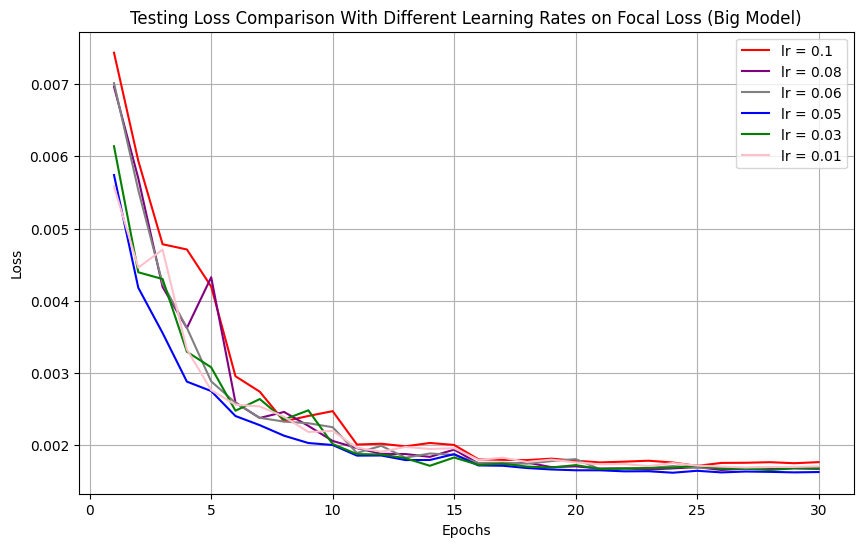

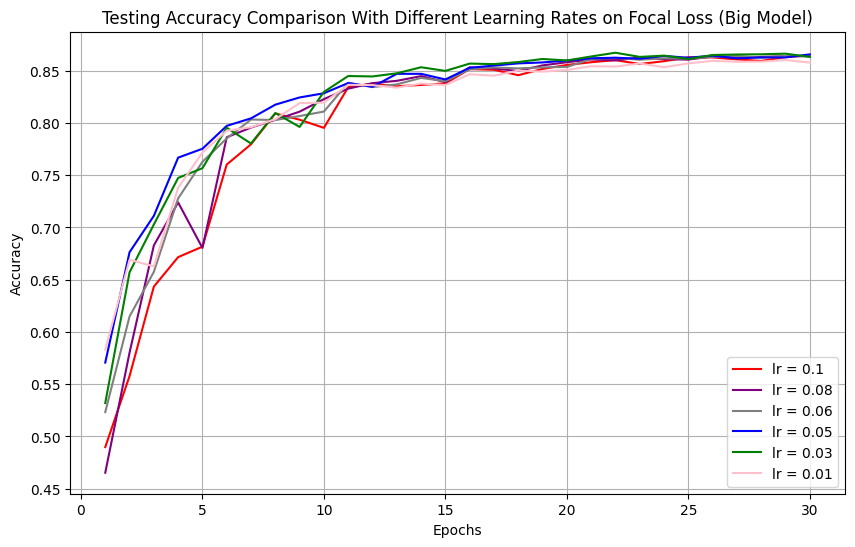

In [24]:
epochs = range(1, len(training_loss_01) + 1)

# 训练损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_01, label='lr = 0.1', color='red')
plt.plot(epochs, training_loss_008, label='lr = 0.08', color='purple')
plt.plot(epochs, training_loss_006, label='lr = 0.06', color='gray')
plt.plot(epochs, training_loss_005, label='lr = 0.05', color='blue')
plt.plot(epochs, training_loss_003, label='lr = 0.03', color='green')
plt.plot(epochs, training_loss_001, label='lr = 0.01', color='pink')
plt.title('Training Loss Comparison With Different Learning Rates on Focal Loss (Big Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_loss__comparison_lr_big.png')
plt.show()

# 训练准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_01, label='lr = 0.1', color='red')
plt.plot(epochs, training_acc_008, label='lr = 0.08', color='purple')
plt.plot(epochs, training_acc_006, label='lr = 0.06', color='gray')
plt.plot(epochs, training_acc_005, label='lr = 0.05', color='blue')
plt.plot(epochs, training_acc_003, label='lr = 0.03', color='green')
plt.plot(epochs, training_acc_001, label='lr = 0.01', color='pink')
plt.title('Training Accuracy Comparison With Different Learning Rates on Focal Loss (Big Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_accuracy__comparison_lr_big.png')
plt.show()

# 测试损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_loss_01, label='lr = 0.1', color='red')
plt.plot(epochs, testing_loss_008, label='lr = 0.08', color='purple')
plt.plot(epochs, testing_loss_006, label='lr = 0.06', color='gray')
plt.plot(epochs, testing_loss_005, label='lr = 0.05', color='blue')
plt.plot(epochs, testing_loss_003, label='lr = 0.03', color='green')
plt.plot(epochs, testing_loss_001, label='lr = 0.01', color='pink')
plt.title('Testing Loss Comparison With Different Learning Rates on Focal Loss (Big Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_loss__comparison_lr_big.png')
plt.show()

# 测试准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_acc_01, label='lr = 0.1', color='red')
plt.plot(epochs, testing_acc_008, label='lr = 0.08', color='purple')
plt.plot(epochs, testing_acc_006, label='lr = 0.06', color='gray')
plt.plot(epochs, testing_acc_005, label='lr = 0.05', color='blue')
plt.plot(epochs, testing_acc_003, label='lr = 0.03', color='green')
plt.plot(epochs, testing_acc_001, label='lr = 0.01', color='pink')
plt.title('Testing Accuracy Comparison With Different Learning Rates on Focal Loss (Big Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_accuracy__comparison_lr_big.png')
plt.show()